# visualizing loss function
Tim Tyre<br>
9.13.2022

In [1]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [3]:
from lib.lib_care.routines.interp_texture_from_scatter_data import interp_txt_from_scatter

# define module

# print exponent of mle fits to full at each $a$ value
Q: which estimators of $a$ did best at reproducing the exponent of mean annihilation rate density observed from the full models?

In [4]:
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)

In [6]:
latest_run_num=29
run_num_lst = list(reversed(list(np.arange(14,latest_run_num+1))))
# run_num_lst=[25,17]
# run_num_lst=[25,19]
# run_num_lst=[25,24]
# run_num_lst = list(np.arange(12,26))
# run_num_lst = list(np.arange(26,14))
run_num_lst=[25,18]
# run_num_lst=[28,18]
run_num_lst=[28,29]
# run_num_lst=[25,29]
# run_num_lst=[30,29]
# run_num_lst=[32,29]
run_num_lst=[32,29]
#note 31==30...
run_num_lst=[28,29]  #what is in Particle_Paper
# run_num_lst=[32,33]
run_num_lst=[35,35]

use_filterby_neighbor=True
# neighbor=0
neighbor=1

use_filterby_minN=True
minN=9

use_filterby_amax=True
min_amax=1.

# neighbor=1
remove_no_diffusion=True
# Dinf=0
Dinf=0.01
num_digits_round_amax=3
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
gmin_fk_lst=[]
gmin_lr_lst=[]
log_dir_fk_lst=[]
log_dir_lr_lst=[]
dict_results_fk_lst=[]
dict_results_lr_lst=[]
# for run_num in [25,18]: #chosen exemplar pair
for run_num in run_num_lst:
    parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
#     parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#     parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
#     input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    #load data
    df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
    df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
    
    #filterby neighbor
    if use_filterby_neighbor:
        df_defects_fk = df_defects_fk[df_defects_fk['neighbor']==neighbor].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['neighbor']==neighbor].copy()
    
    #compute order parameter for each member a=amax-2*D
    #add columns for amax
    df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
    df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
    
    if remove_no_diffusion:
        df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
        
    if use_filterby_amax:
        df_defects_fk = df_defects_fk[df_defects_fk['amax']>min_amax].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['amax']>min_amax].copy()
        
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Fenton-Karma Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=40.
    #supamax=1.8
    #supamax=40.
    for amax,g in df_defects_fk.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_fk=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)
    gmin_fk.sort_values(by='D',inplace=True)
    

    #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    df_defects_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
        gmin_fk_lst.append(gmin_fk)
        log_dir_fk_lst.append(input_fn)
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Luo-Rudy Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=40
    #supamax=10.2
    for amax,g in df_defects_lr.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_lr=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)        
    gmin_lr.sort_values(by='D',inplace=True)
    
    #find best simulation for the full model at this avalue
#     dg_lr=gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()].copy()
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    df_defects_fk['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_lr=dg_fk['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_lr=}")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
        gmin_lr_lst.append(gmin_lr)
        log_dir_lr_lst.append(input_fn)

    print(f"\nparameter range supported in run #{run_num}:")
    print(f"number of trials: {df_defects_lr.shape[0]}")
    print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L','neighbor']].T[['min','max']].T)


**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.9250, rmse_min=0.0443, log_likelihood=129.0630, count=1260

best fit for Fenton-Karma: RMSE: 0.1258 Hz/cm^2, amax: 1.9250 cm^2/s, L: 10.0 cm
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_35_all/job.out.25305603.6684'

**************************************
* Luo-Rudy Model (best settings):
**************************************
amax=11.2440, rmse_min=0.4349, log_likelihood=-3.0334, count=1260

best fit for Luo-Rudy: RMSE: 1.5861 Hz/cm^2, amax: 1.9250 cm^2/s, L: 5.0 cm
input_fn_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_35_all/job.out.25305603.3473'

parameter range supported in run #35:
number of trials: 5040
         r  kappa       D  varkappa    amax     L  neighbor
min  0.050  165.0  0.1290    1.4796   1.781   5.0       1.0
max  0.195  950.0  3.7566    3.8553  11.244  10.0       1.0

**************

In [8]:
run_num=35 #
# run_num=33 #all alinear estimators at L=10
# run_num=32 #all constrained to observed at L=5
# run_num=28  #what is in Particle_Paper
parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'
input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
#     parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#     parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
#     input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
#load data
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
#compute order parameter for each member a=amax-2*D
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)


#filterby neighbor
if use_filterby_neighbor:
    df_defects_fk = df_defects_fk[df_defects_fk['neighbor']==neighbor].copy()
    df_defects_lr = df_defects_lr[df_defects_lr['neighbor']==neighbor].copy()


if remove_no_diffusion:
    df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
    df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()

if use_filterby_amax:
    df_defects_fk = df_defects_fk[df_defects_fk['amax']>min_amax].copy()
    df_defects_lr = df_defects_lr[df_defects_lr['amax']>min_amax].copy()

In [9]:
#identify the lowest error simulation for each amax value
print(f"\n**************************************")
print(f"* Fenton-Karma Model (best settings):")
print(f"**************************************")
minrmse=9999.
supamax=40.
#supamax=1.8
#supamax=40.
gmin_fk_lst=[]
dict_results_fk_lst=[]
for amax,g in df_defects_fk.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    #if (rmse_min<=minrmse)&(amax<=supamax):
    minrmse=rmse_min
    gmin_fk=g.copy()
    gmin_fk.sort_values(by='D',inplace=True)
    print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {count=}, {log_likelihood=:.4f}, {gmin_fk['D'].drop_duplicates().values}"
    print(print_str)
    #TODO: identify xy values of the mle fit
        #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    df_defects_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        #print(f"- best fit RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        #print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
    
    #TODO: estimate powerlaw from xy values
    #Q: howdo not include q too small
    #A: try filter by min_N>10 like before 
    
    #TODO: print the exponent +/- 95%CI for the above powerlaw fit
    

        gmin_fk_lst.append(gmin_fk)


#identify the lowest error simulation for each amax value
print(f"\n**************************************")
print(f"* Luo-Rudy Model (best settings):")
print(f"**************************************")
minrmse=9999.
supamax=40.
#supamax=1.8
#supamax=40.
gmin_lr_lst=[]
dict_results_lr_lst=[]
for amax,g in df_defects_lr.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    #if (rmse_min<=minrmse)&(amax<=supamax):
    minrmse=rmse_min
    gmin_lr=g.copy()
    gmin_lr.sort_values(by='D',inplace=True)
    print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {count=}, {log_likelihood=:.4f}, {gmin_lr['D'].drop_duplicates().values}"
    print(print_str)
    #identify xy values of the mle fit
    #find best simulation for the full model at this avalue
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    df_defects_lr['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_lr=dg_lr['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        #print(f"- best fit RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
    
    #TODO: estimate powerlaw from xy values
    #Q: howdo not include q too small
    #A: try filter by min_N>10 like before 
    
    #TODO: print the exponent +/- 95%CI for the above powerlaw fit
    

        gmin_lr_lst.append(gmin_lr)


#print the best fit exponents
print(f"\n**************************************")
print(f"* the best fit exponents:")
print(f"**************************************")
min_N=9
qmax=0.7

# min_N=20
# qmax=10


# min_N=10
# qmax=1
# qmax=1.5
# min_N=9
# qmax=0.75
# min_N=9
# qmax=0.85

# qmax=1
gmin_lst = list(gmin_fk_lst)
gmin_lst.extend(gmin_lr_lst)
dict_results_lst = list(dict_results_fk_lst)
dict_results_lst.extend(dict_results_lr_lst)
for gmin,dict_results in zip(gmin_lst,dict_results_lst):
    model_name = dict_results['model_name']
    
    dict_linear_fit = dict_results['dict_linear_fit']
    df_fit = dict_results['df_fit']
    df_fit = df_fit[df_fit['N']>min_N].copy()
    x = df_fit['q'].values
    y = df_fit['w'].values
    boo = qmax>x
    dict_fit = print_fit_power_law(x[boo],y[boo],printing=False)
    #dict_fit = print_fit_power_law(x,y,printing=False)

    # print_dict(dict_fit)
    #yhat = dict_fit['M']*x**dict_fit['m']
    # rmsehat = np.sqrt(np.mean((yhat-y)**2))
    # rmsehat #confirmed to match rmse in dict_fit
    # #DONE: plot powerlaw fit for sanity check
    # # plt.plot(x,(y-yhat)/y,'C0')
    # plt.plot(x,(y-yhat),'C0')
    # plt.plot(x,0.*x,'k--')
    # plt.show()

    r = df_fit['r'].median()
    kappa = df_fit['kappa'].median()
    D = df_fit['D'].median()
    a = df_fit['varkappa'].median()
    neighbor = df_fit['neighbor'].median()
    amax= a+2*D

     #DONE: estimate powerlaw from xy values
    #Q: howdo not include q too small
    #A: try filter by min_N>10 like before 

    #TODO: print the exponent +/- 95%CI for the above powerlaw fit
    # dict_fit['M'],dict_fit['m']
    is_model = (model_name=='Fenton-Karma')&(amax<3)
    is_model|= (model_name=='Luo-Rudy')&(amax>3)
    if is_model:
        print(f"- amax: {amax:.4f}, D: {D:.4f} --> exponent: {dict_fit['m']:.4f} +/- {dict_fit['Delta_m']:.4f} ({model_name})")
print(f"exponents were computed with {min_N=} and {qmax=}.")



**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.7810, rmse_min=0.0696, count=1260, log_likelihood=133.5608, [0.129  0.1507]
amax=1.9250, rmse_min=0.0443, count=1260, log_likelihood=129.0630, [0.129  0.1507]
amax=10.1470, rmse_min=0.0777, count=1260, log_likelihood=146.7337, [3.6942 3.7566]
amax=11.2440, rmse_min=0.1824, count=1260, log_likelihood=34.1189, [3.6942 3.7566]

**************************************
* Luo-Rudy Model (best settings):
**************************************
amax=1.7810, rmse_min=1.7585, count=1260, log_likelihood=-10.4738, [0.129  0.1507]
amax=1.9250, rmse_min=1.6643, count=1260, log_likelihood=-9.9549, [0.129  0.1507]
amax=10.1470, rmse_min=0.8920, count=1260, log_likelihood=-6.3162, [3.6942 3.7566]
amax=11.2440, rmse_min=0.4349, count=1260, log_likelihood=-3.0334, [3.6942 3.7566]

**************************************
* the best fit exponents:
**************************************
-

In [36]:
#DONE: go back to computing log-likelihood with s_lst from the apparent rmse as default.
#DONE: dev next run, same as before, 
# but with amax,D given by what's in table 1
# , and with L=10

In [10]:
df_defects_lr['rxn']=df_defects_lr['r']**2*df_defects_lr['kappa']
# df_defects_lr['rxn'].min()

In [11]:
dict_results['dg_fit']['log_likelihood']

6181   -3.033355
Name: log_likelihood, dtype: float64

In [12]:
dict_results.keys()


dict_keys(['model_name', 'amax', 'rmse', 'L', 'df_fit', 'dg_fit', 'dict_linear_fit', 'filename', 'gmin'])

In [13]:
col_lst = ['log_likelihood','varkappa','D','L','neighbor','r','kappa']
gmin_fk[col_lst]
# 'run_num','cluster_index','job_index',
# gmin_fk.columns

,log_likelihood,varkappa,D,L,neighbor,r,kappa
4904,-18.295789,3.8553,3.6942,5.0,1.0,0.110,600.0
4004,-15.459109,3.8553,3.6942,5.0,1.0,0.160,250.0
4005,-127.830080,3.8553,3.6942,10.0,1.0,0.185,300.0
4009,-122.910860,3.8553,3.6942,10.0,1.0,0.140,450.0
4016,-17.660116,3.8553,3.6942,5.0,1.0,0.125,450.0
...,...,...,...,...,...,...,...
4581,-67.316772,3.7305,3.7566,10.0,1.0,0.060,750.0
4592,-20.609361,3.7305,3.7566,5.0,1.0,0.120,750.0
4601,-111.924082,3.7305,3.7566,10.0,1.0,0.180,250.0
4432,-67.659079,3.7305,3.7566,10.0,1.0,0.075,550.0


In [34]:
# #find best simulation for the full model at this avalue
# #     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
# dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
# dg_fk

# plot power law fits grouped by $a_{max}$

In [101]:
num_digits_round_amax=3
run_num=35

In [102]:
#DONE: search for an L=5 data run that has a=1.78,10.147, D=observed from MSR
#DONE: test these last two
# run_num=27 #L=5 
# run_num=30 #L=5 
#TODO(failing ^this): dev run 34 with a=1.78,10.147, D=observed from MSR. and rxn>3, L=5

# run_num=28 #L=5 
# run_num=32 #L=5
# run_num=33 #L=10
powerlaw_fit_dir=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all_powerlaw_fits.csv'
df_powerlaw_fits = pd.read_csv(powerlaw_fit_dir)
df_powerlaw_fits['amax'] = np.around(df_powerlaw_fits['varkappa'] + 2.*df_powerlaw_fits['D'],num_digits_round_amax)
df_powerlaw_fits['rxn'] = df_powerlaw_fits['kappa']*df_powerlaw_fits['r']**2
print(f"{df_powerlaw_fits.shape=}")
print(f"{df_powerlaw_fits.columns=}")
# df_powerlaw_fits.head()
df_powerlaw_fits['L'].drop_duplicates()

df_powerlaw_fits.shape=(10080, 26)
df_powerlaw_fits.columns=Index(['m', 'Delta_m', 'M', 'Delta_M', 'Rsq', 'rmse', 'rmse_full',
       'model_name_full', 'q_min', 'q_max', 'r', 'kappa', 'D', 'varkappa',
       'x0', 'L', 'force_code', 'neighbor', 'reflect', 'set_second',
       'no_repulsion', 'no_attraction', 'dt', 'Dt', 'amax', 'rxn'],
      dtype='object')


0    10
5     5
Name: L, dtype: int64

In [103]:
amax_set_values = df_powerlaw_fits['amax'].drop_duplicates().values 
D_set_values = df_powerlaw_fits['D'].drop_duplicates().values
amax_set_values,D_set_values
#Q: is there any D=observed from MSR?

(array([10.147, 11.244,  1.925,  1.781]),
 array([3.7566, 0.1507, 3.6942, 0.129 ]))

In [104]:
#FK
D_fk = 0.1145
D_fk =  0.1507
# D_fk =  0.129
amax_fk=1.781 #works
# amax_fk= 1.84 #works
# amax_fk= 0.658 #clearly too small
# amax_fk= 1.932  #almost too big
# amax_fk= 2.735 #too big
#LR
D_lr = 0.4158
D_lr = 3.7566
# D_lr = 3.6942
amax_lr= 10.147  #works
# amax_lr= 12.017  #barely too big
# amax_lr= 8.63 #works
# amax_lr= 8.585 #works
title = f'fixing amax,D to {amax_fk}, {D_fk} (FK, black)\n and {amax_lr}, {D_lr} (LR, red)'
# it looks like the mean R works and the mean squared R doesn't for the boe estimate

In [105]:
#recall annihilation rate results from vidmar and rappel (2019)
#Q: do any of the exponents match?
#A: Yes!
# - 1.88 ± 0.031 (FK)
# - 1.638±0.017 (LR)

dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']
#recall powerlaw fits to full
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)
model_str = 'fk_pbc'
# model_str = 'lr_pbc'
# wjr[model_str]

#recall annihilation rate results from vidmar and rappel (2019)
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2
print_fit_power_law(x=fk['q'].values,y=fk['w'].values)

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2
print_fit_power_law(x=lr['q'].values,y=lr['w'].values)

fk_pbc lr_pbc fk_ncbc lr_ncbc
m = 1.877234 +/- 0.024488
M = 5.572316 +/- 0.299027 Hz/cm^2; B=2.496963 +/- 0.039522
RMSE=0.1386 Hz/cm^2; R^2=0.9969; MPE=6.9910%; N=73
m = 1.637556 +/- 0.016847
M = 16.735599 +/- 0.829136 Hz/cm^2; B=5.587740 +/- 0.065801
RMSE=0.1340 Hz/cm^2; R^2=0.9973; MPE=7.2488%; N=100


{'rmse': 0.13399700314367843,
 'mpe': 7.248848701182515,
 'Rsq': 0.9973072227791476,
 'num_obs': 100,
 'm': 1.6375562704001747,
 'Delta_m': 0.016847093884166615,
 'M': 16.73559858353836,
 'Delta_M': 0.8291360607383425,
 'B': 5.587739544416488,
 'Delta_B': 0.06580106796305465}

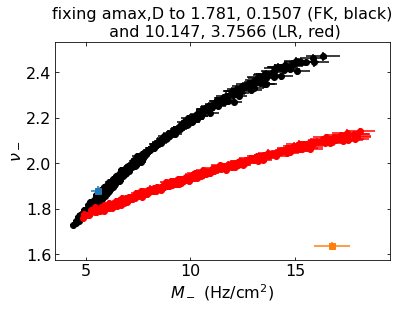

In [106]:
neighbor=1
neighbor=0
L=10
# L=5
fontsize=16
#heretim
fig,ax=plt.subplots(figsize=(6,4))
#plot the FK model
query = neighbor == df_powerlaw_fits['neighbor']
query &= df_powerlaw_fits['amax']==amax_fk
query &= df_powerlaw_fits['D']==D_fk
query &= df_powerlaw_fits['L']==L
M_values,m_values = df_powerlaw_fits[query][['M','m']].values.T
Delta_M_values,Delta_m_values = df_powerlaw_fits[query][['Delta_M','Delta_m']].values.T
ax.errorbar(M_values, m_values, xerr=Delta_M_values, yerr=Delta_m_values, fmt='o',color='k')
#plot the LR model
query = neighbor == df_powerlaw_fits['neighbor']
query &= df_powerlaw_fits['amax']==amax_lr
query &= df_powerlaw_fits['D']==D_lr
query &= df_powerlaw_fits['L']==L
M_values,m_values = df_powerlaw_fits[query][['M','m']].values.T
Delta_M_values,Delta_m_values = df_powerlaw_fits[query][['Delta_M','Delta_m']].values.T
ax.errorbar(M_values, m_values, xerr=Delta_M_values, yerr=Delta_m_values, fmt='o',color='r')

#plot the ground truth
model_str = 'fk_pbc'
ax.errorbar([wjr[model_str]['M']], [wjr[model_str]['m']], xerr=[wjr[model_str]['Delta_M']], yerr=[wjr[model_str]['Delta_m']], fmt='s',color='C0')
model_str = 'lr_pbc'
ax.errorbar([wjr[model_str]['M']], [wjr[model_str]['m']], xerr=[wjr[model_str]['Delta_M']], yerr=[wjr[model_str]['Delta_m']], fmt='s',color='C1')

# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$M_-$ (Hz/cm$^2$)',ylabel=r'$\nu_-$',fontsize=fontsize)
ax.set_title(title,fontsize=fontsize)
plt.show()

In [107]:
# run_num=35 #
# run_num=33 #all alinear estimators at L=10
# run_num=32 #all constrained to observed at L=5
# run_num=28  #what is in Particle_Paper
parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'
input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
#     parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#     parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
#     input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
#load data
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
#compute order parameter for each member a=amax-2*D
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
df_defects_fk['rxn'] = df_defects_fk['kappa']*df_defects_fk['r']**2
df_defects_lr['rxn'] = df_defects_lr['kappa']*df_defects_lr['r']**2

In [124]:
amax_fk_lst=[1.781,1.84,1.932,1.925]
amax_lr_lst=[8.63,10.147,12.017,11.244]
# amax_fk_lst=[1.781,1.84,1.932,1.9252]
# amax_lr_lst=[8.63,10.147,12.017,11.2437]
# amax_fk_lst=[1.932]
# amax_fk_lst=[1.84]
# amax_fk_lst=[1.781]
# amax_lr_lst=[10.147]


In [135]:
df_powerlaw_fits['amax'].drop_duplicates()

0    10.147
1    11.244
3     1.925
9     1.781
Name: amax, dtype: float64

In [133]:
np.isclose(df_powerlaw_fits['amax'],amax,num_digits_round_amax).all()

True

neighbor=0, L=10
amax=1.7810, D=0.1507, r**2*kappa=3.2340, r=0.1400, kappa=165.0000	--> M: 5.5872, nu: 1.8675
amax=1.9250, D=0.1507, r**2*kappa=3.3320, r=0.1400, kappa=170.0000	--> M: 5.9390, nu: 1.8567


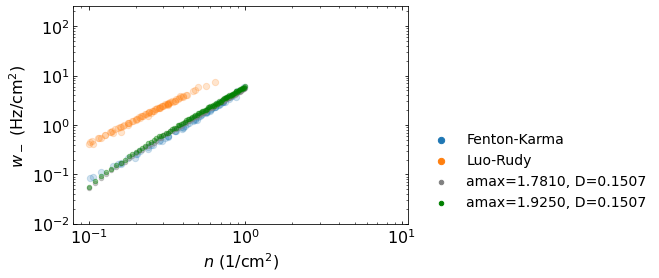

In [136]:
df_defects=df_defects_fk.copy()
D=float(D_fk)
Mscale=0.01
neighbor=1
neighbor=0
# use_filterby_rxn=True
use_filterby_rxn=False
use_filterby_minN=True
minN=10
figsize = (6, 4)  #(5,4)
fontsize=16
# x1lim=[0.008, 11]
x1lim=[0.08, 11]
x2lim=[0.01, 250]
color_lst=['gray','black','purple','green']
# vmax=3
# vmin=1
#plot annihilation rates
fig, ax = plt.subplots(figsize=figsize)
plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)

print(f"{neighbor=}, {L=}")
# for each amax,D setting:
# find the trial with the least square distance (in M,m space from the desired powerlaw fit.
for color,amax in zip(color_lst,amax_fk_lst):
    model_str = 'fk_pbc'
    M = wjr[model_str]['M']
    m = wjr[model_str]['m']
    #query the linear particle model
    query = neighbor == df_powerlaw_fits['neighbor']
    query &= df_powerlaw_fits['amax']==amax
    query &= df_powerlaw_fits['D']==D
    if query.any():
        if use_filterby_rxn:
            query &=df_powerlaw_fits['rxn']<=amax*1.1

        M_values,m_values = df_powerlaw_fits[query][['M','m']].values.T

        annihil_dist_values = Mscale*(M_values-M)**2 + (m_values-m)**2
        #fit the linear particle model
        fit_index = np.argmin(annihil_dist_values)
        g = df_powerlaw_fits[query].iloc[fit_index]
        #DONE: verified the right row is selected
        fit_index = np.argmin(annihil_dist_values)
        #get the job index
        r = g['r']
        kappa = g['kappa']
        L = g['L']
        #     print(f"{amax=:.4f}, {D=:.4f}, {r=:.4f}, {kappa=:.4f} --> M: {M_values[fit_index]=:.4f}, nu: {m_values[fit_index]=:.4f}")
        print(f"{amax=:.4f}, {D=:.4f}, {r**2*kappa=:.4f}, {r=:.4f}, {kappa=:.4f}\t--> M: {M_values[fit_index]:.4f}, nu: {m_values[fit_index]:.4f}")

        query_defects = neighbor == df_defects['neighbor']
        query_defects&= df_defects['amax']==amax
        query_defects&= df_defects['D']==D
        query_defects&= df_defects['L']==L
        query_defects&= df_defects['r']==r
        query_defects&= df_defects['kappa']==kappa
        #print(sum(query_defects))
        cluster_index = int(df_defects[query_defects]['cluster_index'].head(1))
        job_index = int(df_defects[query_defects]['job_index'].head(1))
        # cluster_index = int(df_defects[query_defects]['cluster_index'].tail(1))
        # job_index = int(df_defects[query_defects]['job_index'].tail(1))
        # {job_index}
        input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
        assert os.path.exists(input_fn)
        df_fit,dict_linear_fit = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        # df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        if use_filterby_minN:
            df_fit = df_fit[df_fit['N']>=minN].copy()
        #     df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

        #plot the trial with the least square distance (in M,m space from the desired powerlaw fit.
        df_fit.plot.scatter(x='q',y='w',alpha=0.4,ax=ax,color=color,
                            label=f'{amax=:.4f}, {D=:.4f}')#,vmin=vmin,vmax=vmax,cmap='Greens')
    #     df_fit.plot.scatter(x='q',y='w',alpha=0.7,ax=ax,c=amax+0.*df_fit['q'].values,
    #                         label=f'{amax=:.4f}, {D=:.4f}',vmin=vmin,vmax=vmax,cmap='Greens')

    else:
        print(f"Warning: no powerlaws found: {amax=}")
# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
leg = ax.legend(loc=(1.04,0.04),fontsize=fontsize-2.,frameon=False)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

neighbor=0, L=10
amax=10.1470, D=3.7566, r**2*kappa=10.2675, r=0.1850, kappa=300.0000	--> M: 15.6895, nu: 2.0643
amax=11.2440, D=3.7566, r**2*kappa=9.3712, r=0.1050, kappa=850.0000	--> M: 16.6416, nu: 1.9438


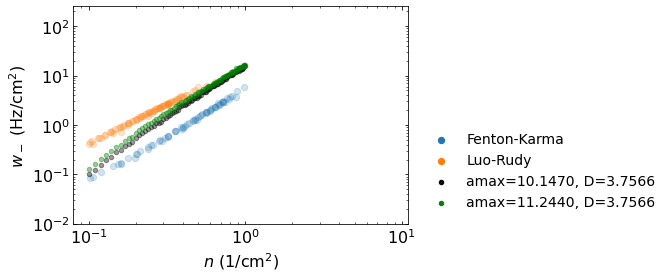

In [141]:
df_defects=df_defects_lr.copy()
D=float(D_lr)
Mscale=0.01
neighbor=1
neighbor=0
# use_filterby_rxn=True
use_filterby_rxn=False
use_filterby_minN=True
minN=10
figsize = (6, 4)  #(5,4)
fontsize=16
# x1lim=[0.008, 11]
x1lim=[0.08, 11]
x2lim=[0.01, 250]
color_lst=['gray','black','purple','green']
# vmax=3
# vmin=1
#plot annihilation rates
fig, ax = plt.subplots(figsize=figsize)
plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)

print(f"{neighbor=}, {L=}")
# for each amax,D setting:
# find the trial with the least square distance (in M,m space from the desired powerlaw fit.
for color,amax in zip(color_lst,amax_lr_lst):
    model_str = 'lr_pbc'
    M = wjr[model_str]['M']
    m = wjr[model_str]['m']
    #query the linear particle model
    query = neighbor == df_powerlaw_fits['neighbor']
    query &= df_powerlaw_fits['amax']==amax
    query &= df_powerlaw_fits['D']==D
    if query.any():
        if use_filterby_rxn:
            query &=df_powerlaw_fits['rxn']<=amax*1.1

        M_values,m_values = df_powerlaw_fits[query][['M','m']].values.T

        annihil_dist_values = Mscale*(M_values-M)**2 + (m_values-m)**2
        #fit the linear particle model
        fit_index = np.argmin(annihil_dist_values)
        g = df_powerlaw_fits[query].iloc[fit_index]
        #DONE: verified the right row is selected
        fit_index = np.argmin(annihil_dist_values)
        #get the job index
        r = g['r']
        kappa = g['kappa']
        L = g['L']
        #     print(f"{amax=:.4f}, {D=:.4f}, {r=:.4f}, {kappa=:.4f} --> M: {M_values[fit_index]=:.4f}, nu: {m_values[fit_index]=:.4f}")
        print(f"{amax=:.4f}, {D=:.4f}, {r**2*kappa=:.4f}, {r=:.4f}, {kappa=:.4f}\t--> M: {M_values[fit_index]:.4f}, nu: {m_values[fit_index]:.4f}")

        query_defects = neighbor == df_defects['neighbor']
        query_defects&= df_defects['amax']==amax
        query_defects&= df_defects['D']==D
        query_defects&= df_defects['L']==L
        query_defects&= df_defects['r']==r
        query_defects&= df_defects['kappa']==kappa
        #print(sum(query_defects))
        cluster_index = int(df_defects[query_defects]['cluster_index'].head(1))
        job_index = int(df_defects[query_defects]['job_index'].head(1))
        # cluster_index = int(df_defects[query_defects]['cluster_index'].tail(1))
        # job_index = int(df_defects[query_defects]['job_index'].tail(1))
        # {job_index}
        input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
        assert os.path.exists(input_fn)
        df_fit,dict_linear_fit = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        # df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        if use_filterby_minN:
            df_fit = df_fit[df_fit['N']>=minN].copy()
        #     df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

        #plot the trial with the least square distance (in M,m space from the desired powerlaw fit.
        df_fit.plot.scatter(x='q',y='w',alpha=0.4,ax=ax,color=color,
                            label=f'{amax=:.4f}, {D=:.4f}')#,vmin=vmin,vmax=vmax,cmap='Greens')
    #     df_fit.plot.scatter(x='q',y='w',alpha=0.7,ax=ax,c=amax+0.*df_fit['q'].values,
    #                         label=f'{amax=:.4f}, {D=:.4f}',vmin=vmin,vmax=vmax,cmap='Greens')

    else:
        print(f"Warning: no powerlaws found: {amax=}")
# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
leg = ax.legend(loc=(1.04,0.04),fontsize=fontsize-2.,frameon=False)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

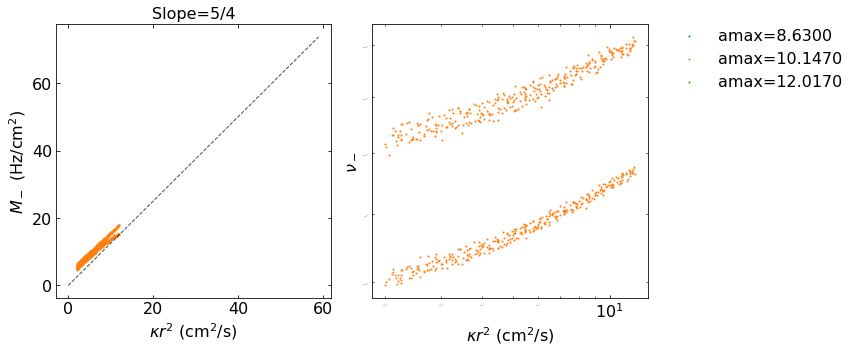

In [146]:

fig,axs=plt.subplots(ncols=2,figsize=(12,5))
for color,amax in zip(color_lst,amax_lr_lst):
    model_str = 'lr_pbc'
    M = wjr[model_str]['M']
    m = wjr[model_str]['m']
    #query the linear particle model
    query = neighbor == df_powerlaw_fits['neighbor']
    query &= df_powerlaw_fits['amax']==amax
    query &= df_powerlaw_fits['D']==D
    M_values,m_values = df_powerlaw_fits[query][['M','m']].values.T
    rxn_values = df_powerlaw_fits[query]['r']**2*df_powerlaw_fits[query]['kappa']
    axs[0].scatter(rxn_values,M_values,label=f'{amax=:.4f}',s=1)
#     axs[1].scatter(rxn_values,m_values/amax,label=f'{amax=:.4f}',s=1)
    axs[1].scatter(rxn_values,m_values,label=f'{amax=:.4f}',s=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

#plot constant slope on axs[0]
xv=np.arange(0,60,1)
axs[0].set_title('Slope=5/4',fontsize=fontsize)
axs[0].plot(xv,1.25*xv,'k--',alpha=0.7,lw=1)#,label='slope=5/4')

#format plots
axs[0].tick_params(top=True, right=True,direction='in',which='both')
axs[1].tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=axs[0],xlabel=r'$\kappa r^2$ (cm$^2$/s)',ylabel=r'$M_-$ (Hz/cm$^2$)',fontsize=fontsize)
format_plot(ax=axs[1],xlabel=r'$\kappa r^2$ (cm$^2$/s)',ylabel=r'$\nu_-$',fontsize=fontsize)
AddLegend(fontsize=fontsize)
plt.tight_layout()
plt.show()

In [468]:
3.64/2

1.82

In [339]:
# # Q: why was this setting run twice
#FIXED
# 167.02*0.14**2

In [147]:
#query best fit
query = r == df_powerlaw_fits['r']
query&= kappa == df_powerlaw_fits['kappa']
query&= D == df_powerlaw_fits['D']
query&= a == df_powerlaw_fits['varkappa']
query&= neighbor == df_powerlaw_fits['neighbor']
df_powerlaw_fits[query]

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt,amax,rxn


In [148]:
#TODO: compute the likelihood to each of the full models, as before

df_powerlaw_fits[query][['r','kappa']]

,r,kappa


In [149]:
0.035**2*600


0.7350000000000001

# Plot mean annihilation rates

In [134]:
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']

In [135]:
# plot_death_rates_loglog_full

run_num_lst=[28, 29]


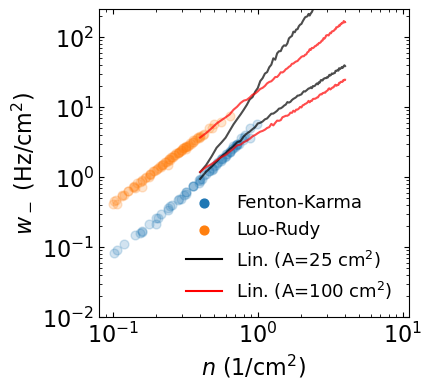

In [136]:
use_filterby_minN=True
minN=10
# minN=8
# figsize = (6, 4)  #(5,4)
figsize = (4, 4)  #(5,4)
fontsize=16

# x1lim=[0.008, 11]
x1lim=[0.08, 11]
x2lim=[0.01, 250]


fig, ax = plt.subplots(figsize=figsize)



ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)

# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[0]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[0]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[0]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Lin. (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Particle (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Linear Particle (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[1]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[1]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[1]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

   
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Lin. (A=100 cm$^2$)')#f'Lin. Particle (L=5)')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Linear Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Linear Particle (L=10)')#,label='_Best Fit to FK')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Lin. Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')

# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# format_plot(ax=ax,xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
# leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()

# x1lim = [8e-3, 1.1]  
# x2lim = [1e-2, 25]
# ax.set_xlim(x1lim)
# ax.set_ylim(x2lim)

#add annotation
# xytext=(0.09, 10)
# xytext=(0.01, 90)
# ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
# .tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)
# xytext=(0.01, 40)
# xy=(0.3, 11)
# ax.annotate(r"$a_{max}$ = const.", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observed", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observation"+f"\nfrom MSR of full", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# #add marker showing the slope of ~2
# annotation.slope_marker(origin=(.75, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
print(f"{run_num_lst=}")
# print(f"{neighbor_lst=}")
plt.show()

# TODO: generate table of $a_{max}$ for the best trial in each data run available

$$a_{max} = a_{linear} + 2D$$

for each of the full models
1. iterate over all defect files cached in .parquet files
1. compute the row for the best fit trial

In [4]:
# print("model, run, L, amax/L**2,  rmse, log_likelihood,")
# dict_fit_lst=[]
# # for each of the full models
# for model_str in ['fk','lr']:
#     # for each defect file cached as .parquet files
#     run_num_lst=reversed(range(27))
#     for run_num in run_num_lst:
#         defect_dir=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#         df_defects_fk=pd.read_parquet(defect_dir)
        
        
        
        
# #         dict_fit=dict(model=model_str,run=run,
# #                       L=L,amax=amax,
# #                       rmse=rmse,log_likelihood=log_likelihood,
# #                       alinear=alinear,D=D,r=r,kappa=kappa,
# #                       cluster_index=cluster_index)

In [5]:
# rmse = df_defects_fk['rmse'].min()
# [rmse==df_defects_fk['rmse']]

In [6]:

#compute a row describing the parameter settings of the trial with the lowest error/loss
#HINT: 
df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)

print(f"{model_str}, {run_num}, {L}, {amax/L**2}, {rmse}, {log_likelihood}")

NameError: name 'input_fn' is not defined

# select data run to visualize

In [11]:
run_num=30 #L=5 cm
# run_num=26 #L=5 cm
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'

# load defects and plot the best fits

In [12]:
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
#compute for each member a=amax-2*D
num_digits_round=2
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round)

In [13]:
# parquet_dir_defects_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_fk.parquet'
# parquet_dir_defects_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_lr.parquet'
parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
# parquet_dir_defects_fk=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
# parquet_dir_defects_lr=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
df_defects_lr.shape

#compute for each member a=amax-2*D
num_digits_round=2
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round)

print(f"parameter range supported in run #{run_num}:")
print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)

#identify the lowest error simulation for each amax value
print(f"\n*******************************")
print(f"* Fenton-Karma Model (best settings):")
print(f"*******************************")
minrmse=9999.
supamax=1.8
for amax,g in df_defects_fk.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    if (rmse_min<=minrmse)&(amax<=supamax):
        minrmse=rmse_min
        print(f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}")
        gmin_fk=g.copy()
    

#identify the lowest error simulation for each amax value
print(f"\n*******************************")
print(f"* Luo-Rudy Model (best settings):")
print(f"*******************************")
minrmse=9999.
supamax=10.2
for amax,g in df_defects_lr.groupby(by='amax'):
    rmse_min = g['rmse'].min()
    count = g['rmse'].count()
    log_likelihood = g['log_likelihood'].max()
    if (rmse_min<=minrmse)&(amax<=supamax):
        minrmse=rmse_min
        print(f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}")
        gmin_lr=g.copy()


parameter range supported in run #30:
               r     kappa           D     varkappa      amax        L
min        0.060    167.02      0.0014      0.42863      0.66      5.0
max        0.195   1614.16      0.4158     12.01420     12.02      5.0
count  11584.000  11584.00  11584.0000  11584.00000  11584.00  11584.0

*******************************
* Fenton-Karma Model (best settings):
*******************************
amax=0.6600, rmse_min=0.6193, log_likelihood=-911.0519, count=1448

*******************************
* Luo-Rudy Model (best settings):
*******************************
amax=0.6600, rmse_min=4.5008, log_likelihood=-3801.7347, count=1448
amax=1.8400, rmse_min=2.8189, log_likelihood=-839.5843, count=1448
amax=1.9300, rmse_min=2.6719, log_likelihood=-740.2604, count=1448
amax=2.7400, rmse_min=1.6616, log_likelihood=-304.3111, count=1448
amax=3.3000, rmse_min=1.0842, log_likelihood=-133.6276, count=1448
amax=8.5900, rmse_min=0.2529, log_likelihood=10.6341, count=1448


In [14]:
dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()]
dg_fk[['cluster_index','job_index']]

,cluster_index,job_index
5557,24328779,2804


In [18]:
#find best simulation for the FK model so far
# input_folder = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
input_folder = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
# cluster_index,job_index = df_defects_fk[df_defects_fk['rmse'] == df_defects_fk['rmse'].min()][['cluster_index','job_index']].values.T
cluster_index,job_index = gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)
input_fn_fk=input_fn


df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_fk)
# print(f"best fit for FK has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
# amax_fk=dict_linear_fit_fk['dict_min']['D']*2+dict_linear_fit_fk['dict_min']['varkappa']
# rmse_fk=dict_defects_fk['rmse']
amax_fk=gmin_fk['amax']
rmse_fk=gmin_fk['rmse']



# print(f"best fit of linear particle model fit to FK ({amax=:.4f}):")
# print_dict(dict_linear_fit_fk['dict_min'])
#DONE: find best simulation for the LR model so far
# cluster_index,job_index = df_defects_lr[df_defects_lr['rmse'] == df_defects_lr['rmse'].min()][['cluster_index','job_index']].values.T
cluster_index,job_index = gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)
input_fn_lr=input_fn

df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_lr)
# print(f"best fit for LR has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
# dict_defects_fk
amax_lr=dict_linear_fit_lr['dict_min']['D']*2+dict_linear_fit_lr['dict_min']['varkappa']
# print(f"best fit of linear particle model fit to LR ({amax=:.4f}):")
# print_dict(dict_linear_fit_lr['dict_min'])
# print(f"src: {input_fn}")

#print the best fitting parameter settings
dict_min_fk=dict_linear_fit_fk['dict_min']
dict_min_fk['model']='Fenton-Karma'

dict_min_lr=dict_linear_fit_lr['dict_min']
dict_min_lr['model']='Luo-Rudy'

print(f"\nparameter settings of best fits:")
print(pd.DataFrame((dict_min_fk,dict_min_lr))\
      .drop(columns=['force_code','q','w','no_attraction','no_repulsion','set_second','niter','reflect','Dt','dt','N','CollTime']))

rmse_lr=dict_defects_lr['rmse']
print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f}, amax: {amax_fk:.4f} ")
print(f"{input_fn_fk=}")
print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f}, amax: {amax_lr:.4f} ")
print(f"{input_fn_lr=}")


parameter settings of best fits:
       r       D    L  kappa  varkappa   x0  neighbor         model
0  0.185  0.0372  5.0  450.0   0.58323  0.0       1.0  Fenton-Karma
1  0.120  0.4158  5.0  350.0   7.75343  0.0       1.0      Luo-Rudy


TypeError: unsupported format string passed to Series.__format__

In [16]:
#plot the original annihilation rates
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']
figsize = (6, 4)  #(5,4)
fontsize=18
fig, ax = plt.subplots(figsize=figsize)
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize)
# ax.legend(loc='upper left',fontsize=fontsize-2)
ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False)
#add annotation
xy=(0.3, 11)
# xytext=(0.09, 10)
xytext=(0.01, 70)
ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
#add marker showing the slope of ~2
# annotation.slope_marker(origin=(2.3, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_tt.csv'

# line plots of minimum locus traced by constant amax=alinear+2D and increasing D

In [136]:
model_name='Fenton-Karma'
amax=float(amax_fk)
gmin=gmin_fk.sort_values(by='D').copy()

# model_name='Luo-Rudy'
# amax=float(amax_lr)
# gmin=gmin_lr.sort_values(by='D').copy()

gmin.head()

,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,q_hi,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax
3,19,0.24,0.96,4.341525,-18.848653,-0.150856,10.680337,-0.150856,10.680337,0.0,...,4.0,6.0,100.0,0.231570,606.060606,0.000066,0.172734,22996017,7420,1.78
11768,19,0.24,0.96,49.177964,-41.913567,-0.107489,108.475116,-0.107489,108.475116,0.0,...,4.0,6.0,100.0,0.274937,2000.000000,0.000020,0.145488,22996017,17436,1.78
11779,19,0.24,0.96,6.015207,-22.292509,-0.152411,14.749156,-0.152411,14.749156,0.0,...,4.0,6.0,100.0,0.230015,909.090909,0.000044,0.173902,22996017,7876,1.78
11783,19,0.24,0.96,15.777854,-33.755643,-0.115355,35.080201,-0.115355,35.080201,0.0,...,4.0,6.0,100.0,0.267071,816.326531,0.000049,0.149773,22996017,16236,1.78
11785,19,0.24,0.96,2.903861,-14.252780,-0.149323,6.419529,-0.149323,6.419529,0.0,...,4.0,6.0,100.0,0.233103,353.982301,0.000113,0.171598,22996017,7304,1.78


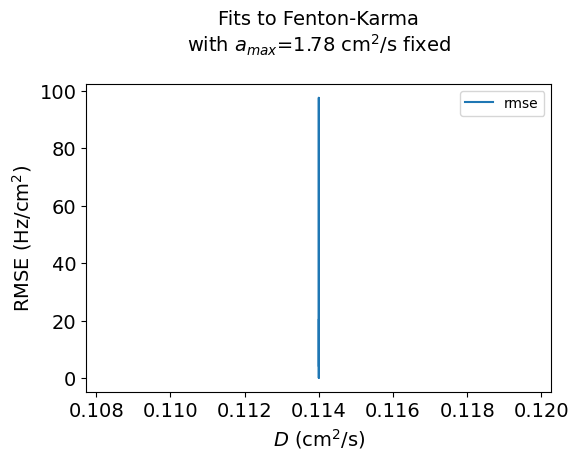

In [137]:
fontsize=14
fig,ax=plt.subplots(figsize=(6,4))
gmin.plot(x='D',y='rmse',ax=ax)
# gmin.plot(x='D',y='log_likelihood')
# gmin.plot(x='D',y='r')
format_plot(ax=ax,xlabel=r'$D$ (cm$^2$/s)',ylabel=r'RMSE (Hz/cm$^2$)',fontsize=fontsize)
ax.set_title("Fits to "+model_name+f'\n'+r'with $a_{max}$='+f'{amax:.2f}'+r' cm$^2$/s'+f' fixed\n',fontsize=fontsize)
plt.show()

# plot loss heatmap in r/L,1/kappa plane 

In [ ]:
print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)

In [ ]:
amax=1.78 #FK 200x200 diffCoeff=0.0005, src: wj

In [9]:
x1_values,x2_values,y_values=interp_txt_from_scatter(X,y)


NameError: name 'X' is not defined

In [ ]:
#generate 2 coordinate grids for the x & y bounds
num_trials,num_neurons = error_code_array.shape
xcoord_values = np.arange(num_trials+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array.copy().T
zerr=error_code_array.copy().T
x.shape,y.shape,z.shape

In [ ]:
#visualize heatmap showing the number of spikes per trial,neuron pair
# title_str = "All"
title = 'Spike Counts For '
title+= title_str + ' Trials\n'
vmin=1
vmax=150.#np.max(z)
# vmax=np.max(z)
# fontsize=14
# figsize=(16,6)
cmap='jet'#'PuBu_r'#
fig, ax = plt.subplots(figsize=figsize,constrained_layout=True)
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
        fontsize=14,xlabel='Trial',ylabel='Neuron')#,**kwargs)
# ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
#                               fontsize=14, xlabel='Trial', ylabel='Neuron', cbar_label='Number of Spikes',
#                               fraction=0.07, shrink=0.85, aspect=35, orientation='horizontal', extend='max')#,**kwargs)
plt.show()

In [ ]:
ax = GridValuePlotter_colorbar(fig,ax,x,y,z,title,cmap,vmin,vmax,
                              fontsize=14, xlabel='Trial', ylabel='Neuron', cbar_label='Number of Spikes',
                              fraction=0.07, shrink=0.85, aspect=35, orientation='horizontal', extend='max')#,**kwargs)

# TODO: visualize the loss function as a stream plot in r,kappa space

# TODO(later): make a sexy 3D plots in r,kappa,alinear space (scaled to L=1)

__Scrum: dev visualization__

1. select dg from df with same amax and neighbors setting
1. for each D in dg plot heat map of r,kappa colored by the Loss function
    - do ibid for Loss=RMSE
    - do ibid for Loss=Neg-Log-Likelihood/Entropy
1. plot the streamplot of the Loss in r,kappa
1. pick a direction to move outward from and measure the increase in Loss as you move away
1. Q: is there a simple functional form in that direction?
1. Q: how does ibid compare to other directions?
